In [1]:
# A simple NLP application that generates word cloud, summarizes most mentioned words, and extracts basic metadata of a document in JSON format.
# This applcition utilzies a number of NLP techniques such as tokenization, bag of words, and NER.
# Author: Paulo Quilao

# Import necessary packages
import os
import re
import sys
import glob
import time
import string
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction.text import CountVectorizer


# Set working environment
pd.set_option("display.max_colwidth", None)
nlp = spacy.load("en_core_web_sm")

In [2]:
# Helper functions
def display_report(path):
    """Displays a table of all reports and respective number of pages."""
    dir_list = os.listdir(path)

    page_df = pd.DataFrame(columns=["reports", "num_pages"])
    page_df["reports"] = dir_list

    for index, doc in enumerate(dir_list):
        pages = glob.glob(os.path.join(path, doc, "*.json"))
        page_df.loc[index, "num_pages"] = len(pages)
    
    page_df = page_df.sort_values("reports").reset_index(drop=True)
    
    return page_df

def display_status_bar():
    """Displays status while a functions is executing."""
    # Display status bar
    for i in range(21):
        sys.stdout.write("\r")
        # the exact output you're looking for:
        sys.stdout.write("[%-20s] %d%%" % ('=' * i, 5 * i))
        sys.stdout.flush()
        time.sleep(0.25)

        
# Functions for reading and cleaning data
def read_all_pages(path, extension="*.json"):
    """Creates a corpus from all the pages of the document."""
    search = os.path.join(path, extension)
    pages = glob.glob(search)
    
    data = []
    for page in pages:
        df = pd.read_json(page)
        for col in df:
            text = df[col].dropna().values[0]
            if text in ["", " "]:
                continue
            data.append(str(text))
            
    return data


def clean_data(text):
    """Preprocess data for word cloud generation."""
    special_char = string.punctuation + "‘’“”°"
    text = text.lower()  # convert to lower case
    text = re.sub("[%s]" % re.escape(special_char), "", text)  # remove punctuations
    text = re.sub("\w*\d\w*", "", text)  # remove numbers
    
    return text  

def create_output_folder():
    """Creates output folder for all derivatives of the application."""
    output_folder = r".\output"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    return output_folder
        

# Functions for visualizing data
def generate_dtm(path):
    """Generates document-term matrix based on the created document."""
    print("\nGenerating document-term matrix...")
    try:
        # Create a corpus based on all the pages of the document
        doc = " ".join(read_all_pages(path))

        # Create a dataframe based on the read document
        doc_df = pd.DataFrame(index=[0])
        doc_df["text"] = doc

        # Clean data: remove numbers, punctuations, white spaces
        data_clean = pd.DataFrame(doc_df["text"].apply(clean_data))

        # Determine token counts
        cv = CountVectorizer(stop_words="english")
        data_cv = cv.fit_transform(data_clean["text"])
        data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())  # document-term matrix
        data_dtm.index = data_clean.index

        print(f"Document-term matrix succesfully created for {report} file.")
        return data_dtm
    
    except Exception as  e:
        print("\nInvalid report name. Please enter the full name of the report.")

    
def create_word_cloud(dtm, save=False):
    """Creates a word cloud based on the passed document-term matrix (DTM)."""
    print(f"Creating word cloud for {report} document...")
    try:        
        # Instantiate word cloud
        wc = WordCloud(stopwords=STOPWORDS, background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

        # Visualize in matplotlib
        fig, ax = plt.subplots(figsize=(16, 6))

        wc.generate_from_frequencies(dtm.transpose()[0])
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")

        if save:
            folder = create_output_folder()
            out_name = f"{report}_word_cloud.jpg"
            op = os.path.join(folder, out_name)
            plt.tight_layout()
            plt.savefig(op, dpi=300)
    
        # Display status bar
        display_status_bar()
        
        return ax
    
    except Exception as e:
        plt.close()
        print("\nInvalid docoment-term matrix (DTM). Please review the passed DTM.")


def generate_summary(df, display_n=5, plot=True, save_csv=False, save_plot=False):
    """
    Plots and writes token counts of the passed document.
    Params: df         : passed data frame
            display_n  : top n most mentioned words
            plot       : constructs horizontal bar graph based on token counts
            save_csv   : writes output to disk in CSV format
            save_plot  : write bar graph to disk in JPG format
    Return: Series/Axes Object
    """
    print(f"Summarizing token counts of {report} document...")       
    try:
        df = df.transpose()
        ret = df[df.columns.values[0]].nlargest(display_n).rename("count")

        if plot:
            plt.style.use("seaborn")

            fig = plt.figure(figsize=(10, 6))
            ax = ret.sort_values().plot.barh(color="lightseagreen")
            ax.set_title(f"Top {display_n} Mentioned Words\n", fontsize=14)
            ax.tick_params(axis="both", labelsize=12)
            ax.set(xlabel="Count", ylabel="Word")

            y = ret.sort_values().values
            for index, val in enumerate(y):
                ax.text(val - 15, index, str(val), va="center", ha="center", color="white", fontweight="bold", size=13)

            if save_plot:
                folder = create_output_folder()
                out_name = f"{report}_Top_{display_n}_words.jpg"
                op = os.path.join(folder, out_name)
                plt.tight_layout()
                fig.savefig(op, dpi=300)
        
            # Display status bar
            display_status_bar()
            return ax
            
        if save_csv:
            folder = create_output_folder()
            out_path = os.path.join(folder, f"{report}_tokencounts.csv")
            df = df.sort_values(0, ascending=False)
            df = df.reset_index().rename(columns= {"index": "word", 0: "count"})
            df.to_csv(out_path, index=False)

        if not plot:
            # Display status bar
            display_status_bar()

        return ret 
    
    except Exception as e:
        plt.close()
        print("Cannot create summary. Please review passed arguments.")
        

# Functions for extracting metadata of the document
def json_to_df(path, extension="*.json"):
    """Creates a data frame from passed JSON files."""
    search = os.path.join(path, extension)
    files = glob.glob(search)
    
    data_df = pd.DataFrame()
    for file in files:
        data = []
        df = pd.read_json(file)
        for col in df:
            text = df[col].dropna().astype(str).values[0].strip()
            if not text:
                continue
            data.append(text)
            
        df = pd.DataFrame(index=[0])
        df["text"] = " ".join(data)
    
        data_df = data_df.append(df, ignore_index=True)
        
    return data_df


def get_operator(row):  
    """Series-level function that filters entity of each record with 'ORG' label."""
    doc = nlp(row)
    possible_ops = [ent for ent in doc.ents if ent.label_ == "ORG"]
    pattern = r"\bCompany\b|\bLtd\b"
    regex = re.compile(pattern)

    for tup in possible_ops:
        matched = regex.findall(str(tup))
        if matched:
            return " ".join([ent.text for ent in tup])
        
        
def get_basin(row):
    """Series-level function that filters entity of each record with 'basin' tag."""
    if "basin" in row.lower():
        doc = nlp(row)
        basin_ents = [ent.text for ent in doc.ents]
        basin_ents = [ent for ent in basin_ents if "basin" in ent.lower()]
        
        ret = nlp(" ".join(basin_ents))
        ret = [token.text for token in ret if not token.is_stop]  # exclude stop words
    
        return ret
    
def extract_metadata(document, save=False):
    """Extracts basic metadata from the document."""
    print(f"Extracting metadata from {report} file...")
    # Create df from json files
    doc_df = json_to_df(document)
    
    # Shell for extracted metadata
    metadata = pd.DataFrame(columns=["operator", "basin"])
        
    # Operator field
    df = doc_df[doc_df.columns.values[0]]
    opr = df.apply(get_operator)
    
    # If there is no match for operator label
    if opr.dropna().index.size == 0:
        operator = None
    else:
        operator = opr[opr.dropna().index[0]]  # get the most relevant match  
        operator = re.sub(r"[\(\)\[\]]", "", operator) # remove brackets and parentheses
        operator = re.sub("\s\s+", " ", operator)  # remove multiple white spaces
    
    # Basin field
    basin = doc_df[doc_df.columns.values[0]].apply(get_basin)  # apply series-level function
    basin = basin.dropna().to_list()

    tagged = []
    for item in basin:
        tagged.extend(item)
        
    text = " ".join(tagged)
    doc = nlp(text)  # create entities based on tagged items
    
    try:
        basin = [ent.text for ent in doc.ents][0]  # return most relevant entity
    except Exception as e:
        basin = None  # return None if tag for basin is empty
    
    # Store extracted entity to metadata df
    metadata.loc[0, "operator"] = operator
    metadata.loc[0, "basin"] = basin
    
    # Display status bar
    display_status_bar()
    
    if save:
        folder = create_output_folder()
        out_name = f"{report}_metadata.csv"
        op = os.path.join(folder, out_name)
        metadata.to_csv(op, index=False)
    
    return metadata    

In [3]:
# Start of Application
# Objectives: 
    # Generate a word cloud and a summary of the desired document using tokenization and bag of words.
    # Extract basic metadata of the document using NER (i.e. operator and name of basin).

# Set constants
test_path = r".\test_data"
reports = display_report(test_path)  
reports

,reports,num_pages
0,Abalone1_FWR,70
1,Abalone_1_Final_Well_Report_Govt,33
2,Acme 1 FWR,59
3,Amulet_1_CH1_Well_Completion_Report_Basic,700
4,Amulet_2_Well_Completion_Report_Basic_W21078A1,480
5,Antiope_1_ST1_Interpretive_Well_Completion_Report_main_text,241
6,Appendix_08_Backpacker_1_BHI_Mudlog_FWR,36
7,Argus-2 and 2ST1 Final Well Completion Report,69
8,Argus_1_Well_Completion_Report_Basic_Data_Vol_Main_Text,438
9,BALNAVES_DEEP-3_SDL_FWR,63


In [4]:
report = input("Please enter the full name of the document to be analyzed from the table above: ").strip()

report_path = os.path.join(test_path, report)
dtm = generate_dtm(report_path)

Please enter the full name of the document to be analyzed from the table above: Well Completion Report FINAL

Generating document-term matrix...
Document-term matrix succesfully created for Well Completion Report FINAL file.


Creating word cloud for Well Completion Report FINAL document...
[====================] 100%

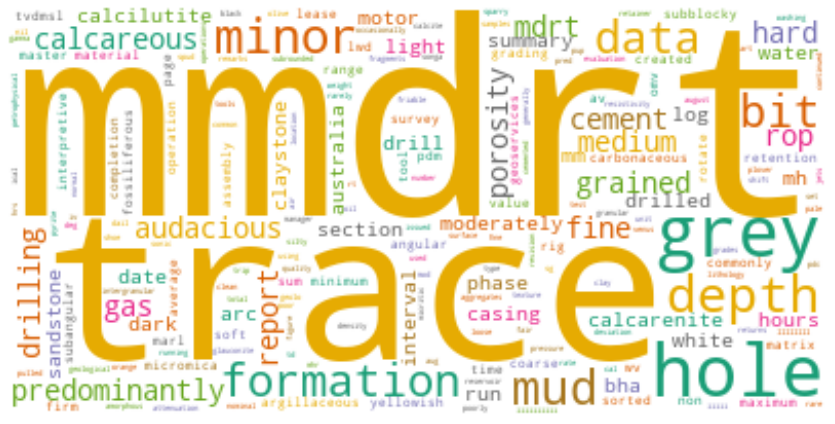

In [5]:
# Create word cloud
# Default params: save=False
word_cloud = create_word_cloud(dtm, save=True)

Summarizing token counts of Well Completion Report FINAL document...
[====================] 100%

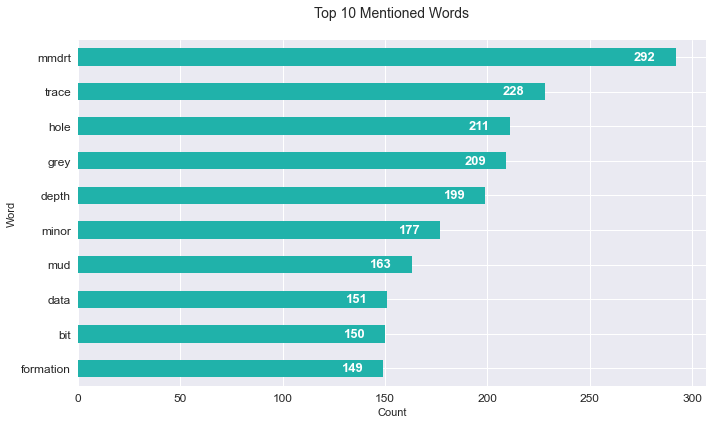

In [6]:
# Summarize content of the document
# Default params: display_n=5, plot=True, save_csv=False, save_plot=False
summ = generate_summary(dtm, display_n=10, save_plot=True)

In [7]:
# Extract metadata using NER
# Default params: save=False
extract_metadata(report_path)

Extracting metadata from Well Completion Report FINAL file...
[====================] 100%

,operator,basin
0,OMV Australia Pty Ltd,Vulcan Sub - basin


In [ ]:
# End of NLP Application